In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# -------------------------------
# Step 1: 读取数据
# -------------------------------
df = pd.read_csv('../../data/intermediate/初步清洗_比赛数据_2.csv',
                 sep=',', engine='python', encoding='utf-8')

# 去除制表符
df = df.map(lambda x: x.strip('\t') if isinstance(x, str) else x)

# -------------------------------
# Step 2: 定义原始特征列（sx_cols）
# -------------------------------
sx_cols = [
    '课前预学','课堂参与','课后复习','延伸阅读',
    '完成作业时间','自习时间','课外阅读时间','网络课程时间',
    '实验科研时间','社团活动时间','竞赛活动时间','其他学习时间',
    '同学合作','参与科研团队','参与学科竞赛','学习同学方法','师生交流频度'
]

# 转为 float
df[sx_cols] = df[sx_cols].astype(float)

In [3]:
# -------------------------------
# Step 3: 数据标准化
# -------------------------------
X = df[sx_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# -------------------------------
# Step 4: PCA 降维
# -------------------------------
# 保留前 6 个主成分（可调整 n_components）
pca = PCA(n_components=7, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA 解释的累计方差比例:", np.sum(pca.explained_variance_ratio_))

PCA 解释的累计方差比例: 0.7598866223865482


PCA 各主成分方差贡献率：
主成分 1: 0.310, 累计: 0.310
主成分 2: 0.163, 累计: 0.473
主成分 3: 0.073, 累计: 0.546
主成分 4: 0.069, 累计: 0.615
主成分 5: 0.051, 累计: 0.666
主成分 6: 0.051, 累计: 0.717
主成分 7: 0.043, 累计: 0.760


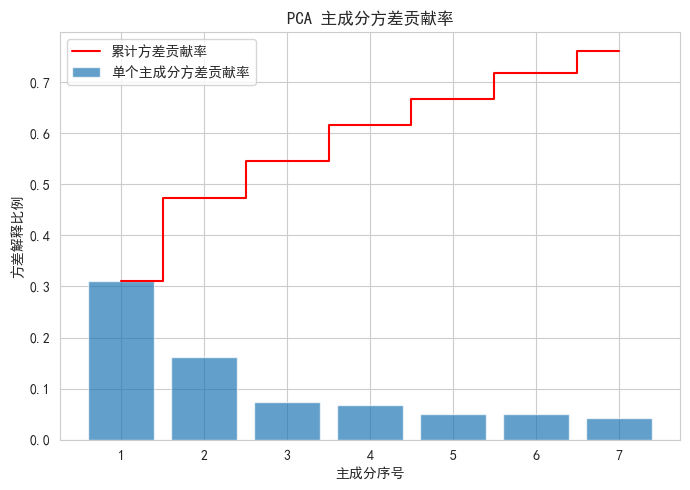

In [5]:
# 输出每个主成分解释的方差比例
explained_ratios = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_ratios)

print("PCA 各主成分方差贡献率：")
for i, ratio in enumerate(explained_ratios, start=1):
    print(f"主成分 {i}: {ratio:.3f}, 累计: {cum_var[i-1]:.3f}")


#可视化方差贡献率

plt.figure(figsize=(7,5))
plt.bar(range(1, len(explained_ratios)+1), explained_ratios, alpha=0.7, align='center', label='单个主成分方差贡献率')
plt.step(range(1, len(cum_var)+1), cum_var, where='mid', label='累计方差贡献率', color='red')

plt.xlabel('主成分序号')
plt.ylabel('方差解释比例')
plt.title('PCA 主成分方差贡献率')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [6]:
import json

# -------------------------------
# Step 5: 生成给前端的 JSON 数据
# -------------------------------
chart_data = {
    "xAxis": [f"主成分{i}" for i in range(1, len(explained_ratios) + 1)],  # 横坐标标签
    "bar": explained_ratios.tolist(),   # 每个主成分的方差贡献率
    "line": cum_var.tolist()            # 累计方差贡献率
}

# 转成 JSON（注意 ensure_ascii=False 保证中文不被转义）
chart_json = json.dumps(chart_data, ensure_ascii=False, indent=2)
print(chart_json)


{
  "xAxis": [
    "主成分1",
    "主成分2",
    "主成分3",
    "主成分4",
    "主成分5",
    "主成分6",
    "主成分7"
  ],
  "bar": [
    0.31040233252697064,
    0.1626172291672862,
    0.07333080913381385,
    0.06880071570447906,
    0.05101947532427003,
    0.050830827952017696,
    0.04288523257771087
  ],
  "line": [
    0.31040233252697064,
    0.47301956169425685,
    0.5463503708280707,
    0.6151510865325498,
    0.6661705618568198,
    0.7170013898088374,
    0.7598866223865482
  ]
}


In [7]:
# 获取每个主成分的特征向量（载荷）
loadings = pca.components_

# 转换成 DataFrame，更直观
loading_df = pd.DataFrame(loadings.T,
                          columns=[f'PC{i+1}' for i in range(loadings.shape[0])],
                          index=['完成作业时间','自习时间','课外阅读时间','网络课程时间','其他学习时间',
                                 '课前预学','课堂参与','课后复习','延伸阅读','学习同学方法',
                                 '实验科研时间','参与科研团队','参与学科竞赛','竞赛活动时间',
                                 '同学合作','社团活动时间','师生交流频度'])

print("PCA 载荷矩阵：")
print(loading_df.round(3))


PCA 载荷矩阵：
          PC1    PC2    PC3    PC4    PC5    PC6    PC7
完成作业时间  0.308 -0.191  0.271 -0.214  0.099  0.033 -0.011
自习时间    0.310 -0.192  0.257 -0.212  0.121  0.060  0.029
课外阅读时间  0.308 -0.183  0.263 -0.207  0.112  0.053  0.000
网络课程时间  0.308 -0.181  0.205 -0.186  0.143 -0.052 -0.040
其他学习时间  0.044  0.148  0.408  0.524  0.020  0.459  0.272
课前预学    0.196  0.378  0.182 -0.006 -0.201 -0.294 -0.044
课堂参与    0.219  0.362  0.150  0.036 -0.072 -0.310 -0.096
课后复习    0.157  0.410  0.215  0.056 -0.226 -0.244 -0.069
延伸阅读    0.179  0.332 -0.295 -0.114  0.306  0.230 -0.040
学习同学方法  0.132 -0.051  0.088  0.608  0.508 -0.085 -0.306
实验科研时间  0.225  0.327 -0.266 -0.133  0.251  0.129 -0.051
参与科研团队  0.114  0.336 -0.056 -0.203  0.028  0.485  0.208
参与学科竞赛  0.270 -0.132 -0.111  0.160 -0.492  0.193 -0.089
竞赛活动时间  0.309 -0.117 -0.367  0.133 -0.010 -0.063 -0.126
同学合作    0.311 -0.111 -0.345  0.137 -0.016 -0.078 -0.145
社团活动时间  0.284 -0.125 -0.095  0.163 -0.420  0.237 -0.020
师生交流频度  0.217 -0.076 -0.194  0.155  0.

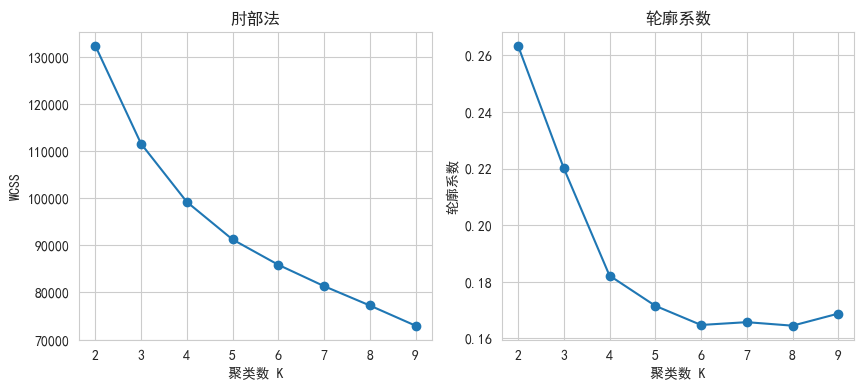

In [8]:
# -------------------------------
# Step 5: 确定聚类数 K (肘部法 + 轮廓系数)
# -------------------------------
wcss = []
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(2,10), wcss, 'o-', label='WCSS')
plt.xlabel('聚类数 K')
plt.ylabel('WCSS')
plt.title('肘部法')

plt.subplot(1,2,2)
plt.plot(range(2,10), silhouette_scores, 'o-', label='轮廓系数')
plt.xlabel('聚类数 K')
plt.ylabel('轮廓系数')
plt.title('轮廓系数')
plt.show()


In [9]:
# -------------------------------
# Step 6: 输出 JSON 数据给前端
# -------------------------------
import json

k_values = list(range(2, 10))

cluster_metrics = {
    "k": k_values,
    "wcss": wcss,
    "silhouette": silhouette_scores
}

# 转成 JSON
metrics_json = json.dumps(cluster_metrics, ensure_ascii=False, indent=2)
print(metrics_json)


{
  "k": [
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9
  ],
  "wcss": [
    132344.86691569278,
    111554.60866224075,
    99210.98628550781,
    91243.06359960242,
    85872.26624278113,
    81347.59751551146,
    77241.26858626751,
    72957.96542254437
  ],
  "silhouette": [
    0.26339974437540487,
    0.22012531774956814,
    0.1821608829199447,
    0.17149771126931257,
    0.16472566339972697,
    0.16571350908401528,
    0.16447327325547345,
    0.16873965689016268
  ]
}


各画像人数分布：
student_persona
学业挣扎型    6345
自主学习型    3659
科研学霸型    2702
社团活跃型    1120
Name: count, dtype: int64

各画像特征均值：
                     课前预学      课堂参与      课后复习      延伸阅读    完成作业时间      自习时间  \
student_persona                                                               
学业挣扎型            0.771946  0.773680  0.771277  0.730299  0.638496  0.132034   
社团活跃型            0.809152  0.815179  0.818304  0.780580  0.633393  0.526847   
科研学霸型            0.952813  0.955311  0.953645  0.934863  0.599812  0.178820   
自主学习型            0.594766  0.604127  0.595996  0.528833  0.528277  0.090697   

                   课外阅读时间    网络课程时间    实验科研时间    社团活动时间    竞赛活动时间    其他学习时间  \
student_persona                                                               
学业挣扎型            0.138731  0.153344  0.060935  0.825533  0.054446  0.065814   
社团活跃型            0.472507  0.503006  0.391027  0.710452  0.428938  0.436016   
科研学霸型            0.177106  0.163706  0.099093  0.851298  0.107356  0.073571   
自主学习型        

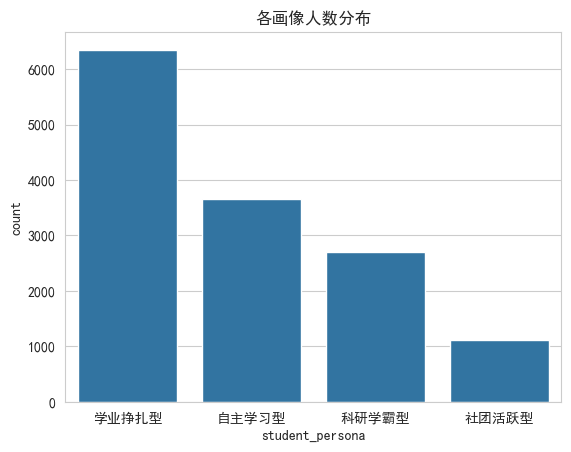

In [10]:
# -------------------------------
# Step 6: 聚类建模 (KMeans, 假设 4 类)
# -------------------------------
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_pca)
# -------------------------------
# Step 7: 映射画像标签 (可人工命名)
# -------------------------------
cluster_mapping = {
    0: '科研学霸型',
    1: '社团活跃型',
    2: '学业挣扎型',
    3: '自主学习型'
}
df['student_persona'] = df['cluster'].map(cluster_mapping)

# -------------------------------
# Step 8: 统计分析
# -------------------------------
print("各画像人数分布：")
print(df['student_persona'].value_counts())

persona_means = df.groupby('student_persona')[sx_cols].mean()
print("\n各画像特征均值：")
print(persona_means)

# -------------------------------
# Step 9: 可视化
# -------------------------------
# (1) 各画像人数柱状图
sns.countplot(x='student_persona', data=df,
              order=df['student_persona'].value_counts().index)
plt.title("各画像人数分布")
plt.show()

In [17]:
# -------------------------------
# Step 10: 输出 JSON 数据
# -------------------------------
import json

# 1. 各画像人数分布
persona_counts = df['student_persona'].value_counts()

# 创建包含 labels 和 values 的格式
result_json = {
    "labels": persona_counts.index.tolist(),  # 画像标签
    "values": persona_counts.values.tolist()  # 对应的人数
}

print(json.dumps(result_json, ensure_ascii=False, indent=2))


{
  "labels": [
    "学业挣扎型",
    "自主学习型",
    "科研学霸型",
    "社团活跃型"
  ],
  "values": [
    6345,
    3659,
    2702,
    1120
  ]
}


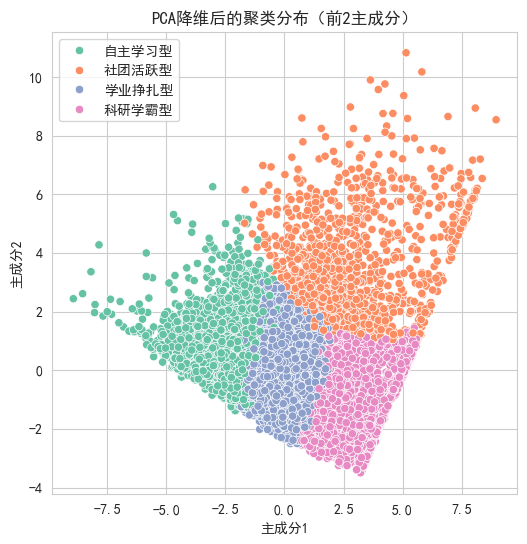

In [12]:
# (2) PCA 前两维度可视化聚类效果
plt.figure(figsize=(6,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['student_persona'], palette="Set2")
plt.title("PCA降维后的聚类分布（前2主成分）")
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.legend()
plt.show() 

In [13]:
pca_df = pd.DataFrame({
    "pc1": X_pca[:, 0],
    "pc2": X_pca[:, 1],
    "student_persona": df["student_persona"]
})
sampled_df = pca_df.sample(n=1000, random_state=42)

# 转成 JSON（records 格式：每个点是一个对象）

pca_json = sampled_df.to_dict(orient="records")
print(json.dumps({"pca_scatter": pca_json}, ensure_ascii=False, indent=2))


{
  "pca_scatter": [
    {
      "pc1": -0.5618248887146101,
      "pc2": -0.560742933593083,
      "student_persona": "学业挣扎型"
    },
    {
      "pc1": -0.6686509143229868,
      "pc2": 1.2703369857217364,
      "student_persona": "学业挣扎型"
    },
    {
      "pc1": -4.890821182923966,
      "pc2": 2.9748877186499647,
      "student_persona": "自主学习型"
    },
    {
      "pc1": 0.4486940644382888,
      "pc2": 0.6121865532417383,
      "student_persona": "学业挣扎型"
    },
    {
      "pc1": -2.639107684853863,
      "pc2": 0.601161631540494,
      "student_persona": "自主学习型"
    },
    {
      "pc1": -0.5940699545196041,
      "pc2": -1.580631978227722,
      "student_persona": "学业挣扎型"
    },
    {
      "pc1": 2.9088794938210216,
      "pc2": -1.4992548358174131,
      "student_persona": "科研学霸型"
    },
    {
      "pc1": -2.5540161076041126,
      "pc2": -0.5970710351424994,
      "student_persona": "自主学习型"
    },
    {
      "pc1": -1.8919120106246188,
      "pc2": -0.4760663702564873,
    

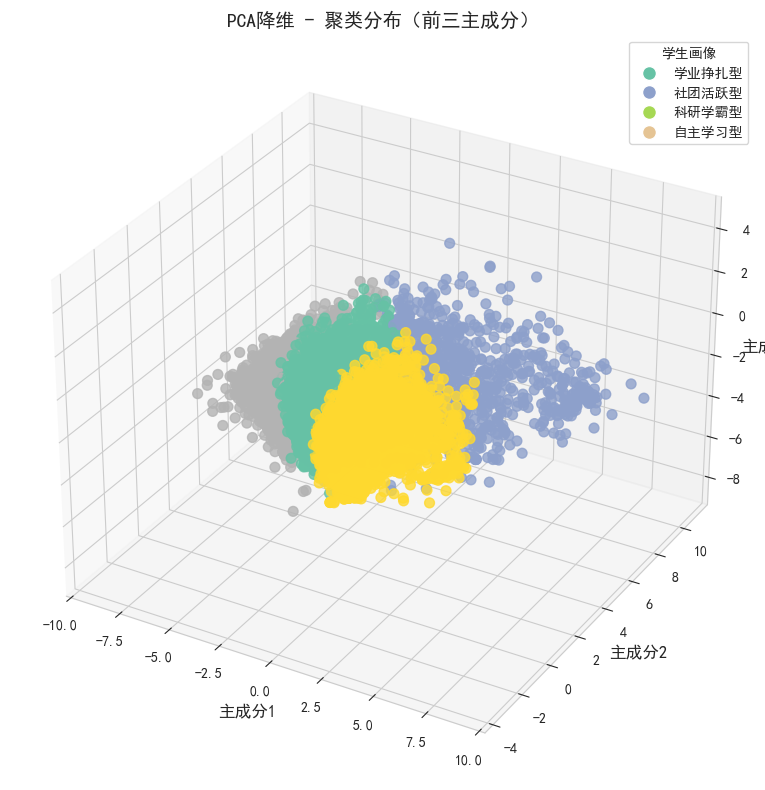

In [14]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建标签编码器
le = LabelEncoder()
# 将字符串标签转换为数值
numeric_labels = le.fit_transform(df['student_persona'])

# (2) PCA 三维聚类结果可视化
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图 - 使用数值标签
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=numeric_labels, cmap="Set2", s=50, alpha=0.8)

# 设置标题和坐标轴标签
ax.set_title("PCA降维 - 聚类分布（前三主成分）", fontsize=14)
ax.set_xlabel("主成分1", fontsize=12)
ax.set_ylabel("主成分2", fontsize=12)
ax.set_zlabel("主成分3", fontsize=12)

# 添加图例 - 需要手动创建图例
legend_labels = le.classes_
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=plt.cm.Set2(i/len(legend_labels)),
                      markersize=10) for i in range(len(legend_labels))]
ax.legend(handles, legend_labels, title="学生画像", loc="upper right", fontsize=10)

# 显示图形
plt.tight_layout()
plt.show()

In [15]:
# -------------------------------
# 输出 PCA 三维散点图的数据为 JSON（随机采样10个点）
# -------------------------------
# 生成包含 PCA 前三维和画像标签的 DataFrame
pca_3d_df = pd.DataFrame({
    "pc1": X_pca[:, 0],
    "pc2": X_pca[:, 1],
    "pc3": X_pca[:, 2],
    "student_persona": df["student_persona"]
})

# 随机采样 10 个点
sampled_df = pca_3d_df.sample(n=1000, random_state=42)

# 转成 JSON（records 格式：每个点是一个对象）
pca_3d_json = sampled_df.to_dict(orient="records")

# 打印 JSON，可直接保存为文件
print(json.dumps({"pca_3d_scatter": pca_3d_json}, ensure_ascii=False, indent=2))

# 如果想保存到文件
# with open("pca_3d_scatter.json", "w", encoding="utf-8") as f:
#     json.dump({"pca_3d_scatter": pca_3d_json}, f, ensure_ascii=False, indent=2)


{
  "pca_3d_scatter": [
    {
      "pc1": -0.5618248887146101,
      "pc2": -0.560742933593083,
      "pc3": 0.4980669459080581,
      "student_persona": "学业挣扎型"
    },
    {
      "pc1": -0.6686509143229868,
      "pc2": 1.2703369857217364,
      "pc3": -0.9996498389203775,
      "student_persona": "学业挣扎型"
    },
    {
      "pc1": -4.890821182923966,
      "pc2": 2.9748877186499647,
      "pc3": -0.2919080565628259,
      "student_persona": "自主学习型"
    },
    {
      "pc1": 0.4486940644382888,
      "pc2": 0.6121865532417383,
      "pc3": 0.11499236533665895,
      "student_persona": "学业挣扎型"
    },
    {
      "pc1": -2.639107684853863,
      "pc2": 0.601161631540494,
      "pc3": 1.147031623722067,
      "student_persona": "自主学习型"
    },
    {
      "pc1": -0.5940699545196041,
      "pc2": -1.580631978227722,
      "pc3": -1.25256357313251,
      "student_persona": "学业挣扎型"
    },
    {
      "pc1": 2.9088794938210216,
      "pc2": -1.4992548358174131,
      "pc3": 0.661524582372807

In [16]:
# =========================
# Step 10: 用 GMM + BIC 客观选择簇数，并进行“软聚类”
# =========================
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd

Ks = range(2, 10)
bics = []
gmms = []

# 建议在“标准化后的原始特征空间 X_scaled”上拟合GMM
for k in Ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    gmms.append(gmm)

best_k = Ks[int(np.argmin(bics))]
best_gmm = gmms[int(np.argmin(bics))]

print("GMM-BIC 选择的最佳簇数:", best_k)

df['gmm_cluster'] = best_gmm.predict(X_scaled)
proba = best_gmm.predict_proba(X_scaled)  # 每个样本对各簇的后验概率
df['gmm_confidence'] = proba.max(axis=1)

# 标记不确定样本（可调整阈值）
uncertain_thr = 0.55
df['gmm_uncertain'] = (df['gmm_confidence'] < uncertain_thr)

# =========================
# Step 11: 用“客观自动命名”给GMM簇命名（基于z值的过度/不足）
# =========================
def build_auto_label(row):
    """根据簇的z值生成自动标签"""
    pos_features = row[row > 1.0].index.tolist()  # z值 > 1 的特征
    neg_features = row[row < -1.0].index.tolist()  # z值 < -1 的特征
    label = "过度: " + ", ".join(pos_features) if pos_features else ""
    label += " | 不足: " + ", ".join(neg_features) if neg_features else ""
    return label.strip(" | ")

Z2 = pd.DataFrame(X_scaled, columns=sx_cols)
Z2['gmm_cluster'] = df['gmm_cluster']
gmm_cluster_z = Z2.groupby('gmm_cluster')[sx_cols].mean()
gmm_auto_names = gmm_cluster_z.apply(build_auto_label, axis=1).to_dict()
df['gmm_persona'] = df['gmm_cluster'].map(gmm_auto_names)

print("GMM 自动标签：", gmm_auto_names)

# 对不确定样本追加说明（可选）
df.loc[df['gmm_uncertain'], 'gmm_persona'] = df.loc[df['gmm_uncertain'], 'gmm_persona'] + "（混合型/不确定）"

# Calculate z-scores for the features
Z = pd.DataFrame(X_scaled, columns=sx_cols)
Z['cluster'] = df['cluster']

# Compute the mean z-scores for each cluster
cluster_z = Z.groupby('cluster')[sx_cols].mean()

# =========================
# Step 12: 画像“特征签名”表（每簇z值排序）
# =========================
def cluster_signature(z_df, topn=5):
    sig = {}
    for c, row in z_df.iterrows():
        order = row.sort_values(ascending=False)
        sig[c] = {
            'top_pos': order.head(topn).round(2).to_dict(),
            'top_neg': order.tail(topn).round(2).to_dict()
        }
    return sig

print("KMeans 簇签名：", cluster_signature(cluster_z, topn=5))
print("GMM 簇签名：", cluster_signature(gmm_cluster_z, topn=5))

# =========================
# Step 13: 可解释规则（用决策树解释 GMM 簇）
# =========================
from sklearn.tree import DecisionTreeClassifier, export_text

tree_gmm = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
tree_gmm.fit(X_scaled, df['gmm_cluster'])
print(export_text(tree_gmm, feature_names=sx_cols))

# =========================
# Step 14: 特征重要性（置换重要度，避免树模型固有偏好）
# =========================
from sklearn.inspection import permutation_importance

perm = permutation_importance(tree_gmm, X_scaled, df['gmm_cluster'],
                              n_repeats=20, random_state=42, n_jobs=-1)
imp = pd.Series(perm.importances_mean, index=sx_cols).sort_values(ascending=False)
print("\n置换重要度：\n", imp.round(4))

# =========================
# Step 15: 个体层面的“与簇均值距离”和“样本轮廓系数”
# =========================
from sklearn.metrics import silhouette_samples, pairwise_distances

# a) 轮廓系数（基于你原先KMeans的标签）
df['km_silhouette'] = silhouette_samples(X_pca, df['cluster'])

# b) 与各簇中心（标准化空间）距离，衡量“典型性”
#    先把KMeans中心从PCA -> 标准化空间
km_centers_scaled = pca.inverse_transform(kmeans.cluster_centers_)
D = pairwise_distances(X_scaled, km_centers_scaled)  # 形状: [n_samples, n_clusters]
df['km_center_dist'] = D.min(axis=1)  # 与所属中心的最小距离

# 标记“非典型个体”（既远离中心又轮廓系数低）
df['km_atypical'] = (df['km_center_dist'] > np.percentile(df['km_center_dist'], 80)) & (df['km_silhouette'] < 0.1)

# =========================
# Step 16: 稳定性简单检测（KMeans重启一致性）
# =========================
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

def km_labels(seed):
    return KMeans(n_clusters=kmeans.n_clusters, random_state=seed, n_init=10).fit_predict(X_pca)

labels_ref = df['cluster'].values
aris = []
for seed in range(43, 53):
    aris.append(adjusted_rand_score(labels_ref, km_labels(seed)))
print("KMeans 重复拟合 ARI（越高越稳定）:", np.round(aris, 3), "平均:", np.mean(aris).round(3))

GMM-BIC 选择的最佳簇数: 9
GMM 自动标签： {0: '过度: 课堂参与', 1: '不足: 社团活动时间', 2: '过度: 自习时间, 网络课程时间, 其他学习时间', 3: '过度: 课前预学, 课堂参与, 课后复习, 延伸阅读, 同学合作, 参与科研团队, 参与学科竞赛, 学习同学方法', 4: '', 5: '', 6: '', 7: '不足: 社团活动时间', 8: '过度: 自习时间, 网络课程时间, 实验科研时间, 竞赛活动时间, 其他学习时间'}
KMeans 簇签名： {0: {'top_pos': {'参与学科竞赛': 1.13, '参与科研团队': 1.13, '课堂参与': 1.08, '课前预学': 1.06, '课后复习': 1.06}, 'top_neg': {'自习时间': 0.08, '实验科研时间': 0.05, '完成作业时间': -0.01, '网络课程时间': -0.08, '其他学习时间': -0.12}}, 1: {'top_pos': {'竞赛活动时间': 2.09, '课外阅读时间': 1.87, '实验科研时间': 1.86, '网络课程时间': 1.85, '自习时间': 1.83}, 'top_neg': {'课堂参与': 0.27, '同学合作': 0.26, '课前预学': 0.26, '完成作业时间': 0.1, '社团活动时间': -0.09}}, 2: {'top_pos': {'社团活动时间': 0.25, '完成作业时间': 0.12, '课前预学': 0.05, '延伸阅读': 0.05, '课后复习': 0.04}, 'top_neg': {'网络课程时间': -0.14, '自习时间': -0.15, '其他学习时间': -0.16, '实验科研时间': -0.18, '竞赛活动时间': -0.2}}, 3: {'top_pos': {'其他学习时间': -0.18, '完成作业时间': -0.24, '网络课程时间': -0.27, '实验科研时间': -0.3, '自习时间': -0.36}, 'top_neg': {'参与学科竞赛': -0.76, '延伸阅读': -0.94, '课后复习': -0.94, '课堂参与': -0.94, '课前预学': -0.94}}}
